# Show, Attend and Tell

[Paper here](https://arxiv.org/pdf/1502.03044)


In [1]:
import re
from random import choice, sample, seed

from rich import print
from tqdm.notebook import tqdm

%load_ext rich

In [252]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import torch
import torchvision.models as models
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters

BATCH_SIZE = 32
N_EPOCHS = 10
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

## Load the dataset


In [4]:
with open("./data/Flickr8k.token.txt") as f:
    captions = f.read().splitlines()

captions[:10]



[
    '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
    '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
    '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
    '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
    '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
    '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
    '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
    '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
    '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
    '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .'
]

In [5]:
captions_dict = {}

for line in captions:
    contents = line.split("\t")

    if len(contents) < 2:
        continue

    filename, caption = contents[0], contents[1]

    filename = filename[:-2]

    if filename in captions_dict.keys():
        captions_dict[filename].append(caption)
    else:
        captions_dict[filename] = [caption]


In [6]:
def get_split_ids(split):
    with open(f"./data/Flickr_8k.{split}Images.txt") as f:
        return f.read().splitlines()

train_ids = get_split_ids("train")
val_ids = get_split_ids("dev")
test_ids = get_split_ids("test")

In [7]:
train_transform = transforms.Compose(
    [
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
    ]
)


In [8]:
def reverse_transform(x, train=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if train:
        x = x * torch.tensor(std).unsqueeze(1).unsqueeze(1)
        x = x + torch.tensor(mean).unsqueeze(1).unsqueeze(1)

    return transforms.ToPILImage()(x)


In [9]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {
            0: "<PAD>",
            1: "<SOS>",
            2: "<EOS>",
            3: "<UNK>",
        }

        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        return text.split()

    def build_vocabulary(self, captions):
        frequencies = {}
        idx = 4

        for caption in captions:
            for word in self.tokenize(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


In [10]:
tokenizer = Vocabulary(freq_threshold=5)

tokenizer.build_vocabulary(
    [caption for captions in captions_dict.values() for caption in captions]
)

print(f"Total number of tokens in vocabulary: {len(tokenizer)}")
print(f'Sample tokenized caption: {tokenizer.numericalize("A black dog is running")}')


Total number of tokens in vocabulary: 2995

Sample tokenized caption: [4, 19, 5, 16, 28]

In [11]:
class CustomCollate:
    def __init__(self, pad_idx, split="train"):
        self.pad_idx = pad_idx
        self.split = split

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        if self.split != "train":
            return (
                imgs,
                targets,
                torch.stack([item[2] for item in batch]).squeeze(1),
                [item[3] for item in batch],
            )

        return imgs, targets, torch.stack([item[2] for item in batch]).squeeze(1)


In [12]:
class Flickr8kDataset(Dataset):
    def __init__(
        self, tokenizer, image_ids, captions_dict, split="train", transform=None
    ):
        self.data = []
        self.transform = transform
        self.tokenizer = tokenizer
        self.split = split

        seed(42)
        for img_id in image_ids:
            if img_id in captions_dict:
                caption = choice(captions_dict[img_id])
                self.data.append((img_id, caption))

        if self.split != "train":
            self.captions_dict = captions_dict

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id, caption = self.data[idx]
        img_path = f"./data/images/{img_id}"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        numericalized_captions = [self.tokenizer.stoi["<SOS>"]]
        numericalized_captions += self.tokenizer.numericalize(caption)
        numericalized_captions.append(self.tokenizer.stoi["<EOS>"])

        if self.split != "train":
            return (
                image,
                torch.tensor(numericalized_captions),
                torch.tensor([len(numericalized_captions)]),
                self.captions_dict[img_id]
            )

        return (
            image,
            torch.tensor(numericalized_captions),
            torch.tensor([len(numericalized_captions)]),
        )


In [13]:
# Create datasets
train_dataset = Flickr8kDataset(
    tokenizer, train_ids, captions_dict, split='train', transform=train_transform
)
val_dataset = Flickr8kDataset(
    tokenizer, val_ids, captions_dict, split='val', transform=test_transform
)
test_dataset = Flickr8kDataset(
    tokenizer, test_ids, captions_dict, split='test', transform=test_transform
)


In [14]:
pad_idx = tokenizer.stoi["<PAD>"]

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CustomCollate(pad_idx=pad_idx),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=pad_idx, split='val'),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=pad_idx, split='test'),
)


In [15]:
len(train_loader), len(val_loader), len(test_loader)

(188, 32, 32)

In [16]:
sample_batch = next(iter(train_loader))

imgs, captions, caplens = sample_batch

print(f"Image batch shape: {imgs.shape}")
print(f"Caption batch shape: {captions.shape}")
print(f"Caption lengths: {caplens.shape}")


Image batch shape: torch.Size([32, 3, 256, 256])

Caption batch shape: torch.Size([32, 22])

Caption lengths: torch.Size([32])

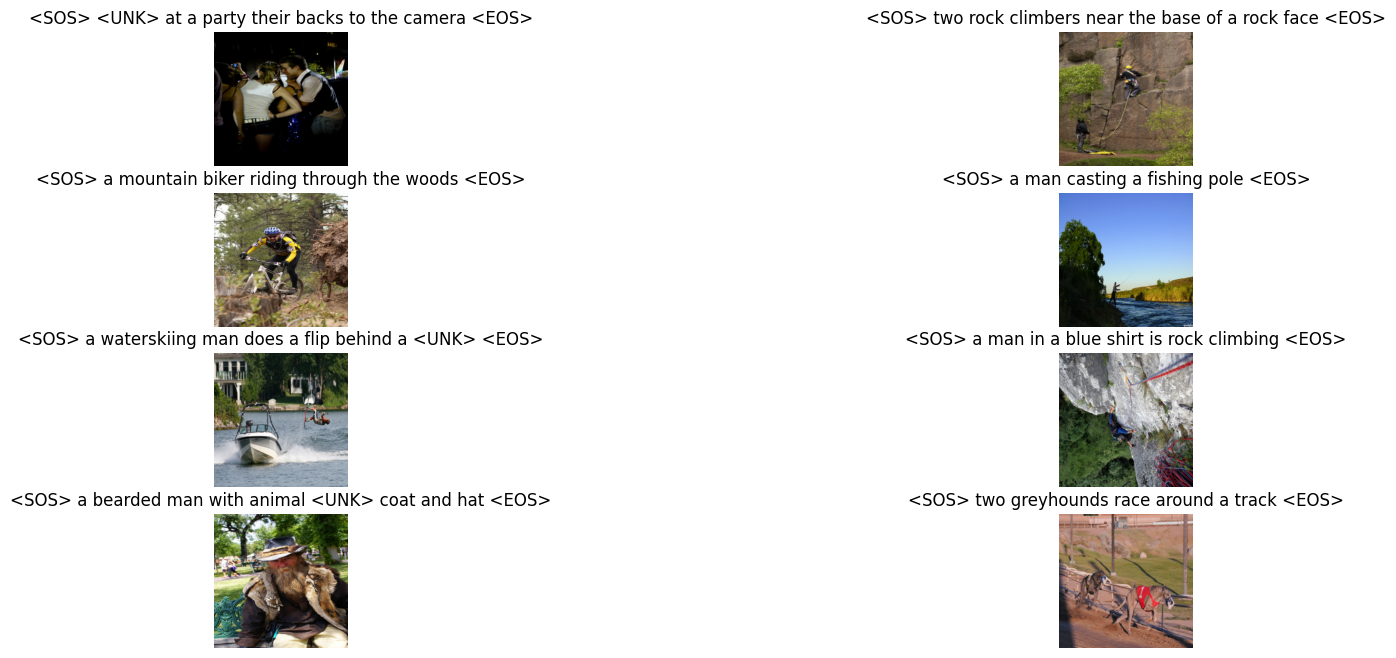

In [17]:
fig, axs = plt.subplots(4, 2, figsize=(20, 8))
for idx in range(8):
    img = imgs[idx]
    label = captions[idx]

    img = reverse_transform(img)
    ax = axs[idx // 2, idx % 2]
    ax.imshow(img)
    ax.set_title(
        f"{' '.join([tokenizer.itos[i.item()] for i in label if i != pad_idx])}"
    )
    ax.axis("off")

plt.show()


## Build the architecture


Tokenized caption: tensor([   1,    4,  924, 1990,    9,  706,   11,    3,   97,    4, 1269,  506,
           4,   64,  507,    2])

Original caption: <SOS> a goalie blocking the goal with <UNK> from a teammate during a hockey game <EOS>

Caption length: tensor([16])

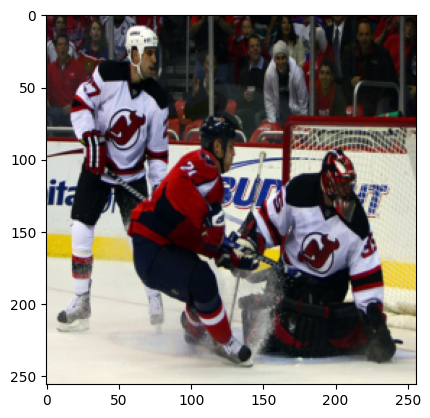

In [18]:
random_idx = 811
img, caption, cap_len = train_dataset[random_idx]
plt.imshow(reverse_transform(img))
print(f"Tokenized caption: {caption}")
print(f'Original caption: {" ".join([tokenizer.itos[i.item()] for i in caption])}')
print(f"Caption length: {cap_len}")

In [19]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14, fine_tune=False, debug=False):
        super(Encoder, self).__init__()

        resnet = models.resnet101(weights="IMAGENET1K_V1")

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(
            (encoded_image_size, encoded_image_size)
        )

        for param in self.resnet.parameters():
            param.requires_grad = False

        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[ENCODER] Input")
        # B x 3 x H x W -> B x 2048 x H/32 x W/32
        x = self.resnet(x)
        self._debug_print(x, "[ENCODER] Resnet")
        # B x 2048 x H/32 x W/32 -> B x 2048 x ENCODED_IMAGE_SIZE x ENCODED_IMAGE_SIZE
        x = self.adaptive_pool(x)
        self._debug_print(x, "[ENCODER] Adaptive Pool")
        # B x 2048 x ENCODED_IMAGE_SIZE x ENCODED_IMAGE_SIZE -> B x ENCODED_IMAGE_SIZE x ENCODED_IMAGE_SIZE x 2048
        x = x.permute(0, 2, 3, 1)
        self._debug_print(x, "[ENCODER] Permute")
        return x


In [20]:
Encoder(debug=True)(img.unsqueeze(0)).shape

[ENCODER] Input: torch.Size([1, 3, 256, 256])

[ENCODER] Resnet: torch.Size([1, 2048, 8, 8])

[ENCODER] Adaptive Pool: torch.Size([1, 2048, 14, 14])

[ENCODER] Permute: torch.Size([1, 14, 14, 2048])

torch.Size([1, 14, 14, 2048])

In [263]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim, debug=False):
        super(Attention, self).__init__()

        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.debug = debug

        self.init_weights()

    def init_weights(self):
        self.encoder_att.weight.data.uniform_(-0.1, 0.1)
        self.encoder_att.bias.data.fill_(0)

        self.decoder_att.weight.data.uniform_(-0.1, 0.1)
        self.decoder_att.bias.data.fill_(0)

        self.full_att.weight.data.uniform_(-0.1, 0.1)
        self.full_att.bias.data.fill_(0)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, image_features, hidden_state):
        """
        image_features: B x PIXEL_SIZE x ENCODER_DIM
        hidden_state: B x DECODER_DIM
        """

        # B x PIXEL_SIZE x ENCODER_DIM -> B x PIXEL_SIZE x ATTENTION_DIM
        encoder_att = self.encoder_att(image_features)
        self._debug_print(encoder_att, "[ATTENTION] Encoder Attention")

        # B x DECODER_DIM -> B x ATTENTION_DIM
        decoder_att = self.decoder_att(hidden_state)
        self._debug_print(decoder_att, "[ATTENTION] Decoder Attention")

        # (B x PIXEL_SIZE x ATTENTION_DIM) + (B x 1 x ATTENTION_DIM) -> B x PIXEL_SIZE x ATTENTION_DIM -> B x PIXEL_SIZE
        attention_score = self.full_att(
            self.relu(encoder_att + decoder_att.unsqueeze(1))
        ).squeeze(2)
        self._debug_print(attention_score, "[ATTENTION] Attention Score")

        # B x PIXEL_SIZE -> B x PIXEL_SIZE
        alpha = self.softmax(attention_score)
        self._debug_print(alpha, "[ATTENTION] Alpha")

        # B x PIXEL_SIZE x ENCODER_DIM (.) B x PIXEL_SIZE x 1 -> B x ENCODER_DIM
        awe = (image_features * alpha.unsqueeze(2)).sum(dim=1)
        self._debug_print(awe, "[ATTENTION] Attention Weighted Image Features")

        return awe, alpha


In [62]:
Attention(encoder_dim=2048, decoder_dim=512, attention_dim=256, debug=True)(
    Encoder()(img.unsqueeze(0)).view(1, -1, 2048), torch.zeros(1, 512)
)


[ATTENTION] Encoder Attention: torch.Size([1, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([1, 256])

[ATTENTION] Attention Score: torch.Size([1, 196])

[ATTENTION] Alpha: torch.Size([1, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([1, 2048])


(
    tensor([[0.5458, 0.4359, 0.7646,  ..., 0.4507, 0.5518, 0.4109]],
       grad_fn=<SumBackward1>),
    tensor([[0.0046, 0.0045, 0.0045, 0.0044, 0.0045, 0.0045, 0.0046, 0.0051, 0.0052,
         0.0053, 0.0056, 0.0059, 0.0064, 0.0070, 0.0047, 0.0044, 0.0042, 0.0042,
         0.0045, 0.0046, 0.0044, 0.0052, 0.0054, 0.0058, 0.0060, 0.0062, 0.0063,
         0.0066, 0.0048, 0.0043, 0.0040, 0.0043, 0.0047, 0.0046, 0.0041, 0.0053,
         0.0055, 0.0058, 0.0063, 0.0064, 0.0063, 0.0062, 0.0051, 0.0047, 0.0044,
         0.0043, 0.0043, 0.0047, 0.0049, 0.0054, 0.0052, 0.0051, 0.0057, 0.0064,
         0.0062, 0.0060, 0.0055, 0.0051, 0.0045, 0.0043, 0.0041, 0.0048, 0.0056,
         0.0060, 0.0052, 0.0047, 0.0056, 0.0064, 0.0061, 0.0058, 0.0054, 0.0053,
         0.0052, 0.0047, 0.0044, 0.0050, 0.0058, 0.0061, 0.0051, 0.0044, 0.0049,
         0.0057, 0.0053, 0.0050, 0.0049, 0.0054, 0.0058, 0.0050, 0.0044, 0.0051,
         0.0061, 0.0058, 0.0047, 0.0039, 0.0041, 0.0045, 0.0042, 0.0041, 0.0051,
 

In [72]:
class Decoder(nn.Module):
    def __init__(
        self,
        embed_dim,
        decoder_dim,
        attention_dim,
        vocab_size,
        encoder_dim=2048,
        dropout=0.5,
        debug=False,
    ):
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim, debug=debug)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)

        self.decoder_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        self.f_beta = nn.Linear(decoder_dim, encoder_dim)

        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def init_hidden_state(self, image_features):
        """
        image_features: B x PIXEL_SIZE x 2048
        """

        mean_image_features = image_features.mean(dim=1)

        # B x 2048 -> B x DECODER_DIM
        h = self.init_h(mean_image_features)
        c = self.init_c(mean_image_features)

        return h, c

    def forward(self, image_features, caption_tokens, caption_lengths):
        """

        image_features: B x ENCODED_IMAGE_SIZE x ENCODED_IMAGE_SIZE x 2048
        caption_tokens: B x CAPTION_LENGTH
        caption_lengths: B
        """

        batch_size = image_features.size(0)
        encoder_dim = image_features.size(-1)

        vocab_size = self.vocab_size
        device = image_features.device

        self._debug_print(image_features, "[DECODER] Image Features")

        image_features = image_features.view(batch_size, -1, encoder_dim)
        pixel_size = image_features.size(1)
        self._debug_print(image_features, "[DECODER] Flattened Image Features")

        self._debug_print(caption_tokens, "[DECODER] Caption Tokens")
        self._debug_print(caption_lengths, "[DECODER] Caption Length")
        caption_lengths, sort_index = caption_lengths.sort(dim=0, descending=True)
        image_features = image_features[sort_index]
        caption_tokens = caption_tokens[sort_index]

        # B x MAX_CAPTION_LENGTH -> B x MAX_CAPTION_LENGTH x EMBED_DIM
        embeddings = self.embedding(caption_tokens)
        self._debug_print(embeddings, "[DECODER] Embeddings")

        h, c = self.init_hidden_state(image_features)

        decode_lengths = (caption_lengths - 1).tolist()

        # B x MAX_CAPTION_LENGTH - 1 x VOCAB_SIZE
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(
            device
        )
        alphas = torch.zeros(batch_size, max(decode_lengths), pixel_size).to(device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])

            awe, alpha = self.attention(image_features[:batch_size_t], h[:batch_size_t])

            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            awe = gate * awe

            if t == 1:
                self._debug_print(awe, "[DECODER] Attention Weighted Image Features")
                self._debug_print(alpha, "[DECODER] Alpha")

                self._debug_print(h, "[DECODER] Hidden State")
                self._debug_print(c, "[DECODER] Cell State")

            h, c = self.decoder_step(
                torch.cat([embeddings[:batch_size_t, t, :], awe], dim=1),
                (h[:batch_size_t], c[:batch_size_t]),
            )

            preds = self.fc(self.dropout(h))

            if t == 1:
                self._debug_print(preds, "[DECODER] Prediction")

            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, caption_tokens, decode_lengths, alphas, sort_index

In [73]:
Decoder(
    embed_dim=512,
    decoder_dim=512,
    attention_dim=768,
    vocab_size=len(tokenizer),
    debug=True,
)(Encoder(debug=True)(imgs), captions, caplens)

[ENCODER] Input: torch.Size([32, 3, 256, 256])

[ENCODER] Resnet: torch.Size([32, 2048, 8, 8])

[ENCODER] Adaptive Pool: torch.Size([32, 2048, 14, 14])

[ENCODER] Permute: torch.Size([32, 14, 14, 2048])

[DECODER] Image Features: torch.Size([32, 14, 14, 2048])

[DECODER] Flattened Image Features: torch.Size([32, 196, 2048])

[DECODER] Caption Tokens: torch.Size([32, 22])

[DECODER] Caption Length: torch.Size([32])

[DECODER] Embeddings: torch.Size([32, 22, 512])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([32, 768])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([32, 768])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[DECODER] Attention Weighted Image Features: torch.Size([32, 2048])

[DECODER] Alpha: torch.Size([32, 196])

[DECODER] Hidden State: torch.Size([32, 512])

[DECODER] Cell State: torch.Size([32, 512])

[DECODER] Prediction: torch.Size([32, 2995])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([32, 768])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([32, 768])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([32, 768])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([31, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([31, 768])

[ATTENTION] Attention Score: torch.Size([31, 196])

[ATTENTION] Alpha: torch.Size([31, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([31, 2048])

[ATTENTION] Encoder Attention: torch.Size([31, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([31, 768])

[ATTENTION] Attention Score: torch.Size([31, 196])

[ATTENTION] Alpha: torch.Size([31, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([31, 2048])

[ATTENTION] Encoder Attention: torch.Size([29, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([29, 768])

[ATTENTION] Attention Score: torch.Size([29, 196])

[ATTENTION] Alpha: torch.Size([29, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([29, 2048])

[ATTENTION] Encoder Attention: torch.Size([25, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([25, 768])

[ATTENTION] Attention Score: torch.Size([25, 196])

[ATTENTION] Alpha: torch.Size([25, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([25, 2048])

[ATTENTION] Encoder Attention: torch.Size([22, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([22, 768])

[ATTENTION] Attention Score: torch.Size([22, 196])

[ATTENTION] Alpha: torch.Size([22, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([22, 2048])

[ATTENTION] Encoder Attention: torch.Size([15, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([15, 768])

[ATTENTION] Attention Score: torch.Size([15, 196])

[ATTENTION] Alpha: torch.Size([15, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([15, 2048])

[ATTENTION] Encoder Attention: torch.Size([13, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([13, 768])

[ATTENTION] Attention Score: torch.Size([13, 196])

[ATTENTION] Alpha: torch.Size([13, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([13, 2048])

[ATTENTION] Encoder Attention: torch.Size([11, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([11, 768])

[ATTENTION] Attention Score: torch.Size([11, 196])

[ATTENTION] Alpha: torch.Size([11, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([11, 2048])

[ATTENTION] Encoder Attention: torch.Size([8, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([8, 768])

[ATTENTION] Attention Score: torch.Size([8, 196])

[ATTENTION] Alpha: torch.Size([8, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([8, 2048])

[ATTENTION] Encoder Attention: torch.Size([5, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([5, 768])

[ATTENTION] Attention Score: torch.Size([5, 196])

[ATTENTION] Alpha: torch.Size([5, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([5, 2048])

[ATTENTION] Encoder Attention: torch.Size([4, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([4, 768])

[ATTENTION] Attention Score: torch.Size([4, 196])

[ATTENTION] Alpha: torch.Size([4, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([4, 2048])

[ATTENTION] Encoder Attention: torch.Size([3, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([3, 768])

[ATTENTION] Attention Score: torch.Size([3, 196])

[ATTENTION] Alpha: torch.Size([3, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([3, 2048])

[ATTENTION] Encoder Attention: torch.Size([2, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([2, 768])

[ATTENTION] Attention Score: torch.Size([2, 196])

[ATTENTION] Alpha: torch.Size([2, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([2, 2048])

[ATTENTION] Encoder Attention: torch.Size([1, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([1, 768])

[ATTENTION] Attention Score: torch.Size([1, 196])

[ATTENTION] Alpha: torch.Size([1, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([1, 2048])

[ATTENTION] Encoder Attention: torch.Size([1, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([1, 768])

[ATTENTION] Attention Score: torch.Size([1, 196])

[ATTENTION] Alpha: torch.Size([1, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([1, 2048])

[ATTENTION] Encoder Attention: torch.Size([1, 196, 768])

[ATTENTION] Decoder Attention: torch.Size([1, 768])

[ATTENTION] Attention Score: torch.Size([1, 196])

[ATTENTION] Alpha: torch.Size([1, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([1, 2048])


(
    tensor([[[ 0.0145, -0.0481,  0.0054,  ..., -0.2636, -0.1778, -0.0967],
         [ 0.0312,  0.0787,  0.0026,  ..., -0.2672,  0.0851, -0.0115],
         [-0.0048,  0.0716,  0.2117,  ..., -0.3100, -0.0175, -0.0345],
         ...,
         [-0.0642, -0.0703,  0.1057,  ..., -0.2722, -0.0813, -0.0233],
         [-0.1328,  0.1509,  0.0944,  ..., -0.0881,  0.0553,  0.0130],
         [-0.1468, -0.3055, -0.1422,  ...,  0.0931,  0.0377,  0.0030]],

        [[ 0.0439, -0.0233, -0.0024,  ..., -0.3588, -0.0945,  0.1322],
         [ 0.0153, -0.0067, -0.0018,  ..., -0.3162, -0.0686,  0.0532],
         [ 0.1508, -0.1678,  0.1951,  ..., -0.3841, -0.1537,  0.0204],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.2140,  0.0568, -0.0024,  ..., -0.1315, -0.1762, -0.2498],
         [ 0.1044,  0.0971,  0.0967,  

In [153]:
class ImageCaptioningModel(nn.Module):
    def __init__(
        self,
        tokenizer,
        encoded_image_size,
        embed_dim,
        decoder_dim,
        attention_dim,
        vocab_size,
        encoder_dim=2048,
        dropout=0.5,
        fine_tune=False,
        debug=False,
    ):
        super(ImageCaptioningModel, self).__init__()

        self.encoder = Encoder(
            encoded_image_size=encoded_image_size, fine_tune=fine_tune, debug=debug
        )
        self.decoder = Decoder(
            embed_dim=embed_dim,
            decoder_dim=decoder_dim,
            attention_dim=attention_dim,
            vocab_size=vocab_size,
            encoder_dim=encoder_dim,
            dropout=dropout,
            debug=debug,
        )

        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, image, caption_tokens, caption_lengths):
        self._debug_print(image, "[MODEL] Image")
        self._debug_print(caption_tokens, "[MODEL] Caption Tokens")
        self._debug_print(caption_lengths, "[MODEL] Caption Lengths")

        image_features = self.encoder(image)
        self._debug_print(image_features, "[MODEL] Image Features")

        predictions, caption_tokens, decode_lengths, alphas, sort_index = self.decoder(
            image_features, caption_tokens, caption_lengths
        )
        self._debug_print(predictions, "[MODEL] Predictions")

        return (
            image_features,
            predictions,
            caption_tokens,
            decode_lengths,
            alphas,
            sort_index,
        )

    def generate_caption_beam_search(self, image, beam_size=5, max_caption_length=20):
        k = beam_size

        device = self.decoder.fc.weight.device

        image_features = self.encoder(image)
        encoded_image_size = image_features.size(1)
        encoder_dim = image_features.size(-1)

        image_features = image_features.view(1, -1, encoder_dim)
        pixel_size = image_features.size(1)

        self._debug_print(image_features, "[BEAM SEARCH] Image Features")

        image_features = image_features.expand(k, pixel_size, encoder_dim)
        self._debug_print(image_features, "[BEAM SEARCH] Image Features - Expanded")

        k_prev_words = torch.LongTensor([[self.tokenizer.stoi["<SOS>"]]] * k).to(device)
        self._debug_print(k_prev_words, "[BEAM SEARCH] Prev Words")

        seqs = k_prev_words

        top_k_scores = torch.zeros(k, 1).to(device)

        seqs_alpha = torch.ones(k, 1, encoded_image_size, encoded_image_size).to(device)

        complete_seqs = list()
        complete_seqs_alphas = list()
        complete_seqs_scores = list()

        step = 1
        h, c = self.decoder.init_hidden_state(image_features)

        self._debug_print(h, "[BEAM SEARCH] Initial hidden State")
        self._debug_print(c, "[BEAM SEARCH] Initial Cell State")

        while True:
            # print("-" * 50)
            # print(f"Step: {step}")
            # K x 1 -> K x 1 x EMBED_DIM -> K x EMBED_DIM
            embeddings = self.decoder.embedding(k_prev_words).squeeze(1)
            # self._debug_print(embeddings, "[BEAM SEARCH] Embeddings")

            # (K x PIXEL_SIZE x ENCODER_DIM, K x DECODER_DIM) -> K x ENCODER_DIM
            awe, alpha = self.decoder.attention(image_features, h)
            gate = self.decoder.sigmoid(self.decoder.f_beta(h))
            awe = gate * awe
            # self._debug_print(awe, "[BEAM SEARCH] Attention Weighted Image Features")

            alpha = alpha.view(-1, encoded_image_size, encoded_image_size)
            # self._debug_print(alpha, "[BEAM SEARCH] Alpha")

            # K x EMBED_DIM -> (K x DECODER_DIM, K x DECODER_DIM)
            h, c = self.decoder.decoder_step(
                torch.cat([embeddings, awe], dim=1), (h, c)
            )

            # self._debug_print(h, "[BEAM SEARCH] Hidden State")
            # self._debug_print(c, "[BEAM SEARCH] Cell State")

            # K x DECODER_DIM -> K x VOCAB_SIZE
            scores = self.decoder.fc(h)
            scores = F.log_softmax(scores, dim=1)
            # self._debug_print(scores, "[BEAM SEARCH] Predicted scores")

            scores = top_k_scores.expand_as(scores) + scores

            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)

            else:
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

            # print(f"Top K Words: {top_k_words}")
            # print(f"Top K Scores: {top_k_scores}")

            prev_word_inds = top_k_words // self.vocab_size
            next_word_inds = top_k_words % self.vocab_size

            # self._debug_print(prev_word_inds, "[BEAM SEARCH] Prev Word Indices")
            # self._debug_print(next_word_inds, "[BEAM SEARCH] Next Word Indices")

            # print(f"Prev Word Indices: {prev_word_inds}")
            # print(f"Next Word Indices: {next_word_inds}")

            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)
            self._debug_print(seqs, "[BEAM SEARCH] Sequences")
            # print(f"Sequences: {seqs}")

            seqs_alpha = torch.cat(
                [seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
            )

            incomplete_inds = [
                ind
                for ind, next_word in enumerate(next_word_inds)
                if next_word != self.tokenizer.stoi["<EOS>"]
            ]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # print(f"Incomplete Indices: {incomplete_inds}")
            # print(f"Complete Indices: {complete_inds}")

            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_alphas.extend(seqs_alpha[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])

            k -= len(complete_inds)

            if k == 0:
                break

            seqs = seqs[incomplete_inds]
            seqs_alpha = seqs_alpha[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]

            image_features = image_features[prev_word_inds[incomplete_inds]]

            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # print(f"Top K Scores: {top_k_scores}")
            # print(f"K Prev Words: {k_prev_words}")

            if step > max_caption_length:
                break

            step += 1

        # If no sequences are completed, return all sequences
        if len(complete_seqs_scores) == 0:
            return seqs, seqs_alpha

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
        alphas = complete_seqs_alphas[i]

        return seq, alphas


In [154]:
model = ImageCaptioningModel(
    tokenizer=tokenizer,
    encoded_image_size=14,
    embed_dim=512,
    decoder_dim=512,
    attention_dim=256,
    vocab_size=len(tokenizer),
    encoder_dim=2048,
    debug=True,
)

In [98]:
_ = model(imgs, captions, caplens)

[MODEL] Image: torch.Size([32, 3, 256, 256])

[MODEL] Caption Tokens: torch.Size([32, 22])

[MODEL] Caption Lengths: torch.Size([32])

[ENCODER] Input: torch.Size([32, 3, 256, 256])

[ENCODER] Resnet: torch.Size([32, 2048, 8, 8])

[ENCODER] Adaptive Pool: torch.Size([32, 2048, 14, 14])

[ENCODER] Permute: torch.Size([32, 14, 14, 2048])

[MODEL] Image Features: torch.Size([32, 14, 14, 2048])

[DECODER] Image Features: torch.Size([32, 14, 14, 2048])

[DECODER] Flattened Image Features: torch.Size([32, 196, 2048])

[DECODER] Caption Tokens: torch.Size([32, 22])

[DECODER] Caption Length: torch.Size([32])

[DECODER] Embeddings: torch.Size([32, 22, 512])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([32, 256])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([32, 256])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[DECODER] Attention Weighted Image Features: torch.Size([32, 2048])

[DECODER] Alpha: torch.Size([32, 196])

[DECODER] Hidden State: torch.Size([32, 512])

[DECODER] Cell State: torch.Size([32, 512])

[DECODER] Prediction: torch.Size([32, 2995])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([32, 256])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([32, 256])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([32, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([32, 256])

[ATTENTION] Attention Score: torch.Size([32, 196])

[ATTENTION] Alpha: torch.Size([32, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([32, 2048])

[ATTENTION] Encoder Attention: torch.Size([31, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([31, 256])

[ATTENTION] Attention Score: torch.Size([31, 196])

[ATTENTION] Alpha: torch.Size([31, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([31, 2048])

[ATTENTION] Encoder Attention: torch.Size([31, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([31, 256])

[ATTENTION] Attention Score: torch.Size([31, 196])

[ATTENTION] Alpha: torch.Size([31, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([31, 2048])

[ATTENTION] Encoder Attention: torch.Size([29, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([29, 256])

[ATTENTION] Attention Score: torch.Size([29, 196])

[ATTENTION] Alpha: torch.Size([29, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([29, 2048])

[ATTENTION] Encoder Attention: torch.Size([25, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([25, 256])

[ATTENTION] Attention Score: torch.Size([25, 196])

[ATTENTION] Alpha: torch.Size([25, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([25, 2048])

[ATTENTION] Encoder Attention: torch.Size([22, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([22, 256])

[ATTENTION] Attention Score: torch.Size([22, 196])

[ATTENTION] Alpha: torch.Size([22, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([22, 2048])

[ATTENTION] Encoder Attention: torch.Size([15, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([15, 256])

[ATTENTION] Attention Score: torch.Size([15, 196])

[ATTENTION] Alpha: torch.Size([15, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([15, 2048])

[ATTENTION] Encoder Attention: torch.Size([13, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([13, 256])

[ATTENTION] Attention Score: torch.Size([13, 196])

[ATTENTION] Alpha: torch.Size([13, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([13, 2048])

[ATTENTION] Encoder Attention: torch.Size([11, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([11, 256])

[ATTENTION] Attention Score: torch.Size([11, 196])

[ATTENTION] Alpha: torch.Size([11, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([11, 2048])

[ATTENTION] Encoder Attention: torch.Size([8, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([8, 256])

[ATTENTION] Attention Score: torch.Size([8, 196])

[ATTENTION] Alpha: torch.Size([8, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([8, 2048])

[ATTENTION] Encoder Attention: torch.Size([5, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([5, 256])

[ATTENTION] Attention Score: torch.Size([5, 196])

[ATTENTION] Alpha: torch.Size([5, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([5, 2048])

[ATTENTION] Encoder Attention: torch.Size([4, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([4, 256])

[ATTENTION] Attention Score: torch.Size([4, 196])

[ATTENTION] Alpha: torch.Size([4, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([4, 2048])

[ATTENTION] Encoder Attention: torch.Size([3, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([3, 256])

[ATTENTION] Attention Score: torch.Size([3, 196])

[ATTENTION] Alpha: torch.Size([3, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([3, 2048])

[ATTENTION] Encoder Attention: torch.Size([2, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([2, 256])

[ATTENTION] Attention Score: torch.Size([2, 196])

[ATTENTION] Alpha: torch.Size([2, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([2, 2048])

[ATTENTION] Encoder Attention: torch.Size([1, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([1, 256])

[ATTENTION] Attention Score: torch.Size([1, 196])

[ATTENTION] Alpha: torch.Size([1, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([1, 2048])

[ATTENTION] Encoder Attention: torch.Size([1, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([1, 256])

[ATTENTION] Attention Score: torch.Size([1, 196])

[ATTENTION] Alpha: torch.Size([1, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([1, 2048])

[ATTENTION] Encoder Attention: torch.Size([1, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([1, 256])

[ATTENTION] Attention Score: torch.Size([1, 196])

[ATTENTION] Alpha: torch.Size([1, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([1, 2048])

[MODEL] Predictions: torch.Size([32, 21, 2995])

In [155]:
generated_caption, generated_alphas = model.generate_caption_beam_search(
    img.unsqueeze(0), beam_size=12, max_caption_length=10
)

for i, c in enumerate(generated_caption):
    print(
        f"Generated caption #{i+1}: {' '.join([tokenizer.itos[i.item()] for i in c])}"
    )


[ENCODER] Input: torch.Size([1, 3, 256, 256])

[ENCODER] Resnet: torch.Size([1, 2048, 8, 8])

[ENCODER] Adaptive Pool: torch.Size([1, 2048, 14, 14])

[ENCODER] Permute: torch.Size([1, 14, 14, 2048])

[BEAM SEARCH] Image Features: torch.Size([1, 196, 2048])

[BEAM SEARCH] Image Features - Expanded: torch.Size([12, 196, 2048])

[BEAM SEARCH] Prev Words: torch.Size([12, 1])

[BEAM SEARCH] Initial hidden State: torch.Size([12, 512])

[BEAM SEARCH] Initial Cell State: torch.Size([12, 512])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 2])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 3])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 4])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 5])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 6])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 7])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 8])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 9])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 10])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 11])

[ATTENTION] Encoder Attention: torch.Size([12, 196, 256])

[ATTENTION] Decoder Attention: torch.Size([12, 256])

[ATTENTION] Attention Score: torch.Size([12, 196])

[ATTENTION] Alpha: torch.Size([12, 196])

[ATTENTION] Attention Weighted Image Features: torch.Size([12, 2048])

[BEAM SEARCH] Sequences: torch.Size([12, 12])

Generated caption #1: <SOS> dots four unfinished unfinished unfinished bee bee bee four soaring coach

Generated caption #2: <SOS> dots four unfinished unfinished unfinished bee bee four palm four palm

Generated caption #3: <SOS> dots four unfinished unfinished unfinished bee bee four unfinished bee four

Generated caption #4: <SOS> dots four unfinished unfinished unfinished bee bee bee four soaring push

Generated caption #5: <SOS> dots four unfinished unfinished unfinished bee bee four unfinished bee bee

Generated caption #6: <SOS> dots four unfinished unfinished unfinished bee bee four palm four soaring

Generated caption #7: <SOS> dots four unfinished unfinished unfinished bee bee four unfinished bee drain

Generated caption #8: <SOS> dots four unfinished unfinished unfinished bee bee drain easter river four

Generated caption #9: <SOS> dots four unfinished unfinished unfinished bee bee drain easter four love

Generated caption #10: <SOS> dots four unfinished unfinished unfinished bee bee drain easter river medals

Generated caption #11: <SOS> dots four unfinished unfinished unfinished bee bee drain easter four soaring

Generated caption #12: <SOS> dots four unfinished unfinished unfinished bee bee four palm four sports

In [161]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")


Total number of parameters in the model: 55670516

## Train the model

In [162]:
def train_step(loader, model, loss_fn, optimizer, epoch):
    model.train()

    losses = []
    for idx, (imgs, captions, caplens) in enumerate(
        tqdm(loader, desc=f"Epoch {epoch}")
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)
        caplens = caplens.to(device)

        (
            image_features,
            predictions,
            caption_tokens,
            decode_lengths,
            alphas,
            sort_index,
        ) = model(imgs, captions, caplens)

        targets = caption_tokens[:, 1:]

        predictions = pack_padded_sequence(
            predictions, decode_lengths, batch_first=True
        )[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        loss = loss_fn(predictions, targets)

        # Doubly stochastic attention regularization
        if alphas is not None:
            loss += (1 - alphas.sum(dim=1) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()

        clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)

In [163]:
def val_step(loader, model, loss_fn, epoch):
    model.eval()

    losses = []
    top5accs = []

    references = list()
    hypotheses = list()

    with torch.no_grad():
        for idx, (imgs, captions, caplens, allcaps) in enumerate(
            tqdm(loader, desc=f"Epoch {epoch}")
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)
            caplens = caplens.to(device)

            (
                image_features,
                predictions,
                caption_tokens,
                decode_lengths,
                alphas,
                sort_index,
            ) = model(imgs, captions, caplens)

            targets = caption_tokens[:, 1:]

            predictions_copy = predictions.clone()

            predictions = pack_padded_sequence(
                predictions, decode_lengths, batch_first=True
            )[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            # Calculate loss
            loss = loss_fn(predictions, targets)

            # Doubly stochastic attention regularization
            if alphas is not None:
                loss += (1 - alphas.sum(dim=1) ** 2).mean()

            # Accuracy@5
            _, ind = predictions.topk(k=5, dim=1, largest=True, sorted=True)
            correct = ind.eq(targets.view(-1, 1).expand_as(ind))
            correct_total = correct.view(-1).float().sum()
            accuracy = correct_total.item() * (100.0 / targets.size(0))

            losses.append(loss.item())
            top5accs.append(accuracy)

            # BLEU evaluation
            # Reference: [[ref1a, ref1b, ref1c], [ref2a, ref2b, ref2c], ...]
            allcaps = [allcaps[i] for i in sort_index]
            for j in range(len(allcaps)):
                img_caps = allcaps[j]

                img_captions = list(
                    tokenizer.tokenize(img_caps[j]) for j in range(len(img_caps))
                )
                references.append(img_captions)

            # Hypothesis: [hyp1, hyp2, ...]
            _, preds = predictions_copy.max(dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(
                    [tokenizer.itos[word] for word in preds[j][: decode_lengths[j]]]
                )

            preds = temp_preds
            hypotheses.extend(preds)

        bleu_4 = corpus_bleu(references, hypotheses)

        return np.mean(losses), np.mean(top5accs), bleu_4


In [269]:
def test_step(loader, model, beam_size=5, max_caption_length=50):
    model.eval()

    references = list()
    hypotheses = list()

    with torch.no_grad():
        for idx, (imgs, captions, caplens, allcaps) in enumerate(
            tqdm(loader, desc="Testing")
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)
            caplens = caplens.to(device)

            final_seqs, _ = model.generate_caption_beam_search(
                imgs, beam_size=beam_size, max_caption_length=max_caption_length
            )

            # BLEU evaluation
            # Reference: [[ref1a, ref1b, ref1c], [ref2a, ref2b, ref2c], ...]
            for j in range(len(allcaps)):
                img_caps = allcaps[j]

                img_captions = list(
                    tokenizer.tokenize(img_caps[j]) for j in range(len(img_caps))
                )
                references.append(img_captions)


            # Hypothesis: [hyp1, hyp2, ...]
            hypotheses.append(
                [
                    tokenizer.itos[word]
                    for word in final_seqs
                    if word
                    not in {
                        tokenizer.stoi["<SOS>"],
                        tokenizer.stoi["<EOS>"],
                        tokenizer.stoi["<PAD>"],
                    }
                ]
            )

        bleu_4 = corpus_bleu(references, hypotheses)

    return bleu_4


In [236]:
model = ImageCaptioningModel(
    tokenizer=tokenizer,
    encoded_image_size=14,
    embed_dim=512,
    decoder_dim=512,
    attention_dim=768,
    vocab_size=len(tokenizer),
    encoder_dim=2048,
    debug=False,
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.RMSprop(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 56982772

In [237]:
for epoch in tqdm(range(1), desc="Epochs"):
    train_loss = train_step(train_loader, model, criterion, optimizer, epoch)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}")

    val_loss, val_top5acc, val_bleu = val_step(val_loader, model, criterion, epoch)
    print(
        f"Epoch: {epoch} | Val Loss: {val_loss:.4f} | Val Top-5 Acc: {val_top5acc:.2f} | Val BLEU-4: {val_bleu:.4f}"
    )

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 4.8121

Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0 | Val Loss: 4.3095 | Val Top-5 Acc: 51.24 | Val BLEU-4: 0.0390

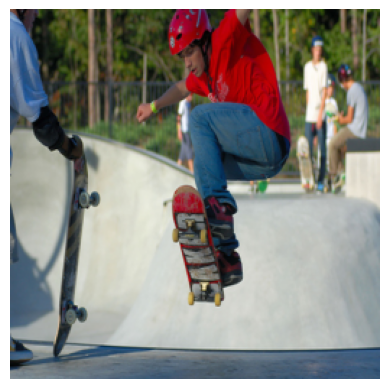

In [259]:
test_img, test_caption, _, test_allcaps = test_dataset[23]

plt.imshow(reverse_transform(test_img, train=False))
plt.axis("off")
plt.show()


In [260]:
gen_caption, gen_alphas = model.generate_caption_beam_search(
    test_img.to(device).unsqueeze(0), beam_size=5, max_caption_length=40
)

print(f"Generated caption: {' '.join([tokenizer.itos[i] for i in gen_caption])}")
print(f'True caption: {" ".join([tokenizer.itos[i.item()] for i in test_caption if i != pad_idx])}')

print(f'All reference captions: {test_allcaps}')

Generated caption: <SOS> a man in a red shirt is running in the grass <EOS>

True caption: <SOS> a young man wearing a red jacket performs a jump on a red skateboard <EOS>

All reference captions: ['A man wearing a red helmet jumps up while riding a skateboard .', 'A young man wearing a 
red jacket performs a jump on a red skateboard .', 'The helmeted boy is doing a stunt on a skateboard .', 'The 
young man is skateboarding at a skate park .', 'Young man is performing a trick on a skateboard in a park .']

In [275]:
def visualize_model_attention(image, generated_caption, alphas, tokenizer, smooth=True):
    alphas = torch.FloatTensor(alphas)

    image = reverse_transform(image, train=False)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    caption = [tokenizer.itos[i] for i in generated_caption]

    plt.figure(figsize=(10, 6))
    for t in range(len(caption)):
        plt.subplot(int(np.ceil(len(caption) / 5.0)), 5, t + 1)

        plt.text(0, 1, caption[t], color="black", backgroundcolor="white", fontsize=12)
        plt.imshow(image)

        alpha = alphas[t, :]

        if smooth:
            alpha = skimage.transform.pyramid_expand(alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(alpha.numpy(), [14 * 24, 14 * 24])

        if t == 0:
            plt.imshow(alpha, alpha=0.0)
        else:
            plt.imshow(alpha, alpha=0.7)

        plt.set_cmap("grey")
        plt.axis("off")

    plt.show()


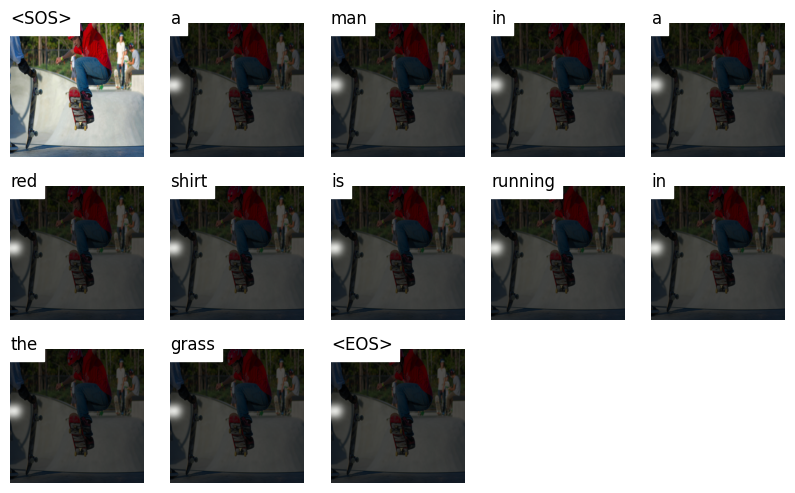

In [276]:
visualize_model_attention(test_img, gen_caption, gen_alphas, tokenizer)

In [270]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=pad_idx, split="test"),
)

test_step(test_loader, model, beam_size=5, max_caption_length=20)


Testing:   0%|          | 0/1000 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│   5 │   collate_fn=CustomCollate(pad_idx=pad_idx, split="test"),                                 │
│   6 )                                                                                            │
│   7                                                                                              │
│ ❱ 8 test_step(test_loader, model, beam_size=5, max_caption_length=20)                            │
│   9                                                                                              │
│                                                                                                  │
│ in test_step:15                                                                                  │
│                                                                                                  │
│   12 │   │   │   captions = captions.to(device)                                                  │
│   13 │   │   │   caplens = caplens.to(device)                                                    │
│   14 │   │   │                                                                                   │
│ ❱ 15 │   │   │   final_seqs, _ = model.generate_caption_beam_search(                             │
│   16 │   │   │   │   imgs, beam_size=beam_size, max_caption_length=max_caption_length            │
│   17 │   │   │   )                                                                               │
│   18                                                                                             │
│                                                                                                  │
│ in generate_caption_beam_search:65                                                               │
│                                                                                                  │
│    62 │   │                                                                                      │
│    63 │   │   device = self.decoder.fc.weight.device                                             │
│    64 │   │                                                                                      │
│ ❱  65 │   │   image_features = self.encoder(image)                                               │
│    66 │   │   encoded_image_size = image_features.size(1)                                        │
│    67 │   │   encoder_dim = image_features.size(-1)                                              │
│    68                                                                                            │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:1532 in     │
│ _wrapped_call_impl                                                                               │
│                                                                                                  │
│   1529 │   │   if self._compiled_call_impl is not None:                                          │
│   1530 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1531 │   │   else:                                                                             │
│ ❱ 1532 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1533 │                                                                                         │
│   1534 │   def _call_impl(self, *args, **kwargs):                                                │
│   1535 │   │   forward_call = (self._slow_forward if torch._C._get_tracing_state() else self.fo  │
│                                                            